Read satellite data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def read_satellite_data(veg_type, satellite):
    # Load vegetation class table
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    # Filter for Forest classes
    if veg_type in (11, 12, 13, 14):
        df = df[df['veg_class'].isin([veg_type])]#.iloc[0:1000]
    else:
        df = df[df['veg_class'].isin([11, 12, 13, 14])]#.iloc[0:1000]
    
    # Separate climate/phenology columns by type
    eos_cols = [col for col in df.columns if 'eos' in col]
    t_cols = [col for col in df.columns if 'annual_t' in col]
    p_cols = [col for col in df.columns if 'annual_p' in col]
    sos_cols = [col for col in df.columns if 'sos' in col]

    if satellite == "avhrr":
        years = [str(y) for y in range(1982, 2017)]
    elif satellite == "modis":
        years = [str(y) for y in range(2001, 2024)]
        # Build boolean masks
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
    else:
        years = [str(y) for y in range(2013, 2023)]
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
        
    cols = years
    df = df[[col for col in eos_cols + t_cols + p_cols + sos_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
    t_cols_df = [col for col in df.columns if 'annual_t' in col]
    df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
    df.columns = df.columns.str.replace(r'\D*(\d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
    df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
    df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
    df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
    df['sos'] = df[[col for col in df.columns if 'sos' in col]].mean(axis=1)
    return df

In [2]:
## Plot moving windows for AVHRR

In [ ]:
## Heat map for SOS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.ticker import FormatStrFormatter

def filter_extremes(df, x_col, y_col, z_col):
    x_all = df[x_col].values
    y_all = df[y_col].values*1000
    z_all = df[z_col].values
    x_low, x_high = np.nanpercentile(x_all, [0, 100])
    y_low, y_high = np.nanpercentile(y_all, [0, 100])
    mask = (x_all >= x_low) & (x_all <= x_high) & (y_all >= y_low) & (y_all <= y_high)
    return x_all[mask], y_all[mask], z_all[mask]

def classify_data(x, y):
    # temp_class = np.where(x < np.nanmean(x), 'low temp', 'High temp')
    temp_class = np.where(x < 6.5, 'low temp', 'High temp')
    precip_class = np.where(y < 900, 'Low prcp', 'High prcp')
    return temp_class, precip_class


def compute_binned_means(x, y, z, min_z_count):
    bin_width_x = 0.5     # 1 degree
    bin_width_y = 100   # 100 mm/year

    # Compute bin edges
    x_edges = np.arange(np.floor(x.min()), np.ceil(x.max()) + bin_width_x, bin_width_x)
    # y_edges = np.arange(np.floor(y.min()), np.ceil(y.max()) + bin_width_y, bin_width_y)
    y_start = np.floor(y.min() / bin_width_y) * bin_width_y
    y_end = np.ceil(y.max() / bin_width_y) * bin_width_y
    y_edges = np.arange(y_start, y_end + bin_width_y, bin_width_y)

    # 2D histogram: sum and count
    z_sum, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=z)
    z_count, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])

    # Compute mean where count >= threshold
    z_mean = np.full_like(z_sum, np.nan, dtype=np.float64)
    valid_mask = z_count >= min_z_count
    z_mean[valid_mask] = z_sum[valid_mask] / z_count[valid_mask]
    
    # Calculate bin centers for plotting
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
   
    print(f'Max count of grid: {np.nanmax(z_count)}')
    # z_mean_masked = np.where((z_mean >= 200) & (z_mean <= 340), z_mean, np.nan)
    z_mean_masked = z_mean
    print(np.nanmin(z_mean_masked))

    return z_mean_masked, x_centers, y_centers

def plot_main_heatmap(x, y, z_mean, name1, name2, x_bins, y_bins, x_display_range, y_display_range, vlim, satellite):
    # ax = plt.subplot2grid((3, 4), (0, 1), rowspan=2, colspan=2)
    ax = plt.subplot2grid((6, 4), (0, 1), rowspan=3, colspan=2)

    cmap = LinearSegmentedColormap.from_list(
        "custom_cmap",
        ["#0b3c68", "#165188", "#2066a8", "#4d91c4", "#8ec1da", 
         "#fbebe1", "#f6d6c2", "#d47264", "#c14d48", "#ae282c"]
    )

    vmin, vmax = vlim
    norm = Normalize(vmin=vmin if vmin is not None else np.nanmin(z_mean),
                     vmax=vmax if vmax is not None else np.nanmax(z_mean))

    # Recover bin edges from centers
    x_step = x_bins[1] - x_bins[0]
    y_step = y_bins[1] - y_bins[0]
    x_edges = np.concatenate([[x_bins[0] - x_step / 2], x_bins + x_step / 2])
    y_edges = np.concatenate([[y_bins[0] - y_step / 2], y_bins + y_step / 2])

    ax.imshow(z_mean.T, origin='lower',
              extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
              cmap=cmap, norm=norm, aspect='auto')


    ax.set_xlim(*x_display_range)
    ax.set_ylim(*y_display_range)
    ax.set_yticks([400, 800, 1200, 1600])

    ax.set_ylabel("MAP (mm/year)", fontsize=14)
    ax.set_xticklabels([])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if satellite == 'avhrr':
        ax.axhline(y=900, color='black', linestyle='--', linewidth=1.0)
        ax.vlines(x=7.25, ymin=ax.get_ylim()[0], ymax=900, 
          colors='black', linestyles='--', linewidth=1.0)
    elif satellite == 'modis':
        ax.axhline(y=1000, color='black', linestyle='--', linewidth=1.0)
        ax.vlines(x=6.75, ymin=ax.get_ylim()[0], ymax=1000, 
              colors='black', linestyles='--', linewidth=1.0)
    else: 
        ax.axhline(y=1100, color='black', linestyle='--', linewidth=1.0)
        ax.vlines(x=7.25, ymin=ax.get_ylim()[0], ymax=1100, 
              colors='black', linestyles='--', linewidth=1.0)
    # Wet regions (nudge left and down a bit)
    ax.text(x_display_range[1] - 0.5,   # move left by 0.5 units
            y_display_range[1] - 50,   # move down by 50 units
            "Wet regions",
            ha='right', va='top', fontsize=10, color='black')
    
    # Dry regions (nudge left and up a bit)
    ax.text(x_display_range[1] - 0.5,   # move left by 0.5 units
            y_display_range[0] + 50,   # move up by 50 units
            "Hot-dry regions",
            ha='right', va='bottom', fontsize=10, color='black')
    # Dry regions (nudge left and up a bit)
    ax.text(x_display_range[1] - 15,   # move left by 0.5 units
            y_display_range[0] + 18,   # move up by 50 units
            "Cold-dry regions",
            ha='right', va='bottom', fontsize=10, color='black')

    return ax, norm

def add_colorbar(fig, norm, z_col, vlim):
    ax_cbar = fig.add_axes([0.7, 0.55, 0.015, 0.35])
    cmap = LinearSegmentedColormap.from_list("custom_cmap",
            ["#0b3c68", "#165188", "#2066a8", "#4d91c4", "#8ec1da", 
            "#fbebe1", "#f6d6c2", "#d47264", "#c14d48", "#ae282c"])

    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_cbar)
    if vlim == (55, 145):
        cbar.set_ticks([60, 80, 100, 120, 140])
    elif vlim == (61, 175):
        cbar.set_ticks([80, 100, 120, 140, 160])
    else:
        cbar.set_ticks([120, 140, 160, 180])
    cbar.ax.set_ylabel("SOS (DOY)", fontsize=14)

    cbar.ax.tick_params(labelsize=12)


def plot_heat_map(df, x_col, y_col, z_col, name1, name2, name3, title, vlim, min_z_count, satellite):
    x_display_range = (-7, 20)
    y_display_range = (300, 1750)
    x, y, z = filter_extremes(df, x_col, y_col, z_col)
    temp_class, precip_class = classify_data(x, y)

    z_mean, x_bins, y_bins = compute_binned_means(x, y, z, min_z_count)
    mid_x = (x_bins[:-1] + x_bins[1:]) / 2
    mid_y = (y_bins[:-1] + y_bins[1:]) / 2
    fig = plt.figure(figsize=(12, 6)) 

    ax2 = plot_bottom_subplot(x, y, z_mean, x_bins, y_bins, precip_class, mid_x, x_display_range, z, vlim, satellite)
    ax_main, norm = plot_main_heatmap(x, y, z_mean, name1, name2, x_bins, y_bins, x_display_range, y_display_range, vlim, satellite)
    add_colorbar(fig, norm, z_col, vlim)
    fig.subplots_adjust(left=0.08, right=0.88, top=0.92, bottom=0.08, hspace=0.7, wspace=0.3)
    plt.show()
    return fig


def plot_grid(df, name1, name2, name3, title, vlim, min_z_count, satellite):
    return plot_heat_map(df, name1, name2, name3, name1, name2, name3, title, vlim, min_z_count, satellite)

In [ ]:
## Bottom plot with original data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_bottom_subplot(x, y, z_mean, x_bins, y_bins, precip_class, mid_x, x_display_range, z, vlim, satellite):
    ax = plt.subplot2grid((8, 4), (4, 1), colspan=2, rowspan=3)

    # Precip classification
    if satellite == 'avhrr':
        thresh = 900
    elif satellite == 'modis':
        thresh = 1000
    else:
        thresh = 1100
    low_mask = y < thresh
    high_mask = y >= thresh

    # Bin temperature into 0.5 °C bins (xx.25, xx.75)
    def bin_to_half_degree(vals):
        return np.floor(vals * 2) / 2 + 0.25

    x_binned = bin_to_half_degree(x)
    bin_mids = np.unique(np.sort(x_binned))

    # Compute mean/std EOS for each bin
    def binned_stats(x_vals, z_vals, bins, x_min, x_max):
        means, stds, mids = [], [], []
        for xm in bins:
            if xm < x_min or xm > x_max:
                continue
            mask = x_vals == xm
            if np.any(mask):
                means.append(np.nanmean(z_vals[mask]))
                stds.append(np.nanstd(z_vals[mask]))
                mids.append(xm)
        return np.array(mids), np.array(means), np.array(stds)

    if satellite == 'avhrr':
        pos11 = 0.1
        pos12 = 0.5
        pos21 = 0.7
        pos22 = 0.2
        dlim1 = -6.5
        dlim2 = 12
        wlim1 = -4.5
        wlim2 = 20
    elif satellite == 'modis':
        pos11 = 0.1
        pos12 = 0.3
        pos21 = 0.7
        pos22 = 0.2
        dlim1 = -7.5
        dlim2 = 13
        wlim1 = -3.5
        wlim2 = 20
    else:
        pos11 = 0.1
        pos12 = 0.25
        pos21 = 0.7
        pos22 = 0.2
        dlim1 = -7.5
        dlim2 = 13.5
        wlim1 = -3.5
        wlim2 = 20

    mids_low, z_low_mean, z_low_std = binned_stats(x_binned[low_mask], z[low_mask], bin_mids, dlim1, dlim2)
    mids_high, z_high_mean, z_high_std = binned_stats(x_binned[high_mask], z[high_mask], bin_mids, wlim1, wlim2)
    
    # Plot low prcp mean ± std
    ax.fill_between(mids_low, z_low_mean - z_low_std, z_low_mean + z_low_std,
                    color='#e03c31', alpha=0.15)
    ax.plot(mids_low, z_low_mean, color='#e03c31', lw=2, label="Low prcp")

    # Plot high prcp mean ± std
    ax.fill_between(mids_high, z_high_mean - z_high_std, z_high_mean + z_high_std,
                    color='gray', alpha=0.15)
    ax.plot(mids_high, z_high_mean, color='gray', lw=2, label="High prcp")

    from matplotlib.lines import Line2D
    # Custom legend handles with colored lines (no markers)
    custom_legend = [
        Line2D([0], [0], color='gray', lw=5, label='Wet regions'),
        Line2D([0], [0], color='#e03c31', lw=5, label='Dry regions'),
    ]
    # Add legend with formatting
    leg = plt.legend(
        handles=custom_legend,
        fontsize=10,
        frameon=False,       # Remove legend box, optional
        loc='lower left',    # fixed location: upper left
        handlelength=1.0,    # Shorter line length
        handleheight=0.8     # More compact spacing
    )
    # Thicker legend lines (alreaday set via lw=5, but this is redundant safety)
    for line in leg.get_lines():
        line.set_linewidth(7)
    # --- Axis formatting ---
    ax.set_xlim(*x_display_range)
    ax.set_xlabel("MAT (°C)", fontsize=14)
    ax.set_ylabel("SOS (DOY)", fontsize=14)
    ax.tick_params(labelsize=12)
    return ax

Plot Extended Data Fig. 2

Max count of grid: 2793.0
113.26413502109709


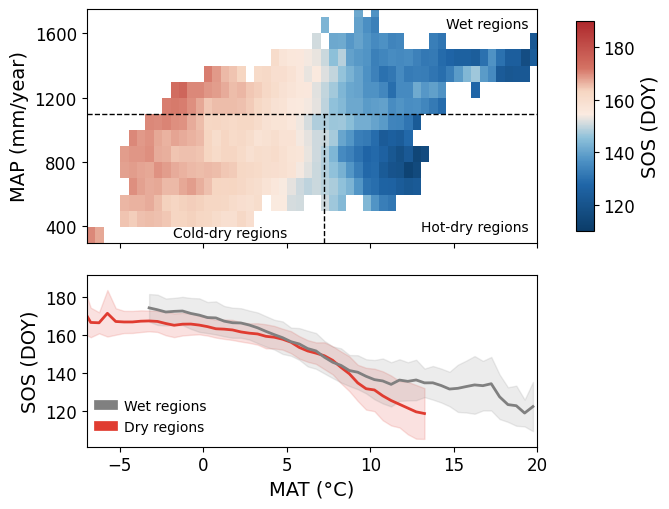

In [8]:
satellite = 'avhrr'
# satellite = 'modis'
# satellite = 'viirs'

veg_type = 0
df = read_satellite_data(veg_type, satellite)

min_z_count = 50
if satellite == "avhrr":
    min_eos, max_eos = 55, 145
elif satellite == "modis":
    min_eos, max_eos = 61, 175
else:
    min_eos, max_eos = 110, 190

figa = plot_grid(df, 'annual_t', 'annual_p', 'sos', 'SOS', (min_eos, max_eos), min_z_count, satellite)
figa.savefig(f"../results/ed_figures/ed_fig5/{satellite}_sos.png", dpi=300, bbox_inches='tight')